In [376]:
# ----------------- #
# Scarlet 1 testing #
# ----------------- #
# Import Packages and setup
import numpy as np
import pandas as pd
import cmasher as cmr
import scarlet 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap=cmr.fall, interpolation='none', origin='lower')

In [395]:
""" 
Notes on data
-------------
Dataframe is stored in a pickled pandas dataframe. To collect the data, use the following code
where 'parent_ID' filtering is since I grab the full scene, but then also every individual source
just for completeness. For using Scarlet we only every need the full scene entry hence why
all the columns are calling the 0th entry for the filtered parent_ID. Parent IDs run in increasing order
where 0 correspeonds to scenes with one object, and [-1] to the soruces with the maximum number of objects per scene.
For this, I removed most the data for storage size but I have the full dataset.
Can use this as a test for how Scarlet 1 ane Scarlet 2 performs on identical datasets. The whole analysis code is just 
from the scarlet quickstart guide.
""" 

# good example it doesnt do well on: 14060 - try scarlet 2 on this maybe
# a cool one is 14080 - use this for paper
# Data check
data_name = 'HSC_tract_' + str(9697) + '_patch_' + str(72) + '_subset.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name)
data = df[df['parent_ID']==df['parent_ID'][14080]] # select one randome scene
print(data.info())

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
                        np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 14079 to 14084
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   parent_ID   6 non-null      int64 
 1   object_num  6 non-null      int64 
 2   box_x       6 non-null      int64 
 3   box_y       6 non-null      int64 
 4   tract       6 non-null      int64 
 5   patch       6 non-null      int64 
 6   box_sz      6 non-null      int64 
 7   loc         6 non-null      object
 8   scar_g      6 non-null      object
 9   scar_i      6 non-null      object
 10  scar_r      6 non-null      object
 11  scar_y      6 non-null      object
 12  scar_z      6 non-null      object
 13  PSF_g       6 non-null      object
 14  PSF_i       6 non-null      object
 15  PSF_r       6 non-null      object
 16  PSF_y       6 non-null      object
 17  PSF_z       6 non-null      object
 18  var_g       6 non-null      object
 19  var_i       6 non-null      object
 20  var_r 

In [378]:
# Load the sample images
images = multi_images 
masks = multi_filters
filters = np.array(['g','i','r','y','z'],dtype='<U1') # explicitly make filter list
centers = np.array( data['loc'] )
weights = 1/multi_var 
psf = scarlet.ImagePSF( multi_psf )

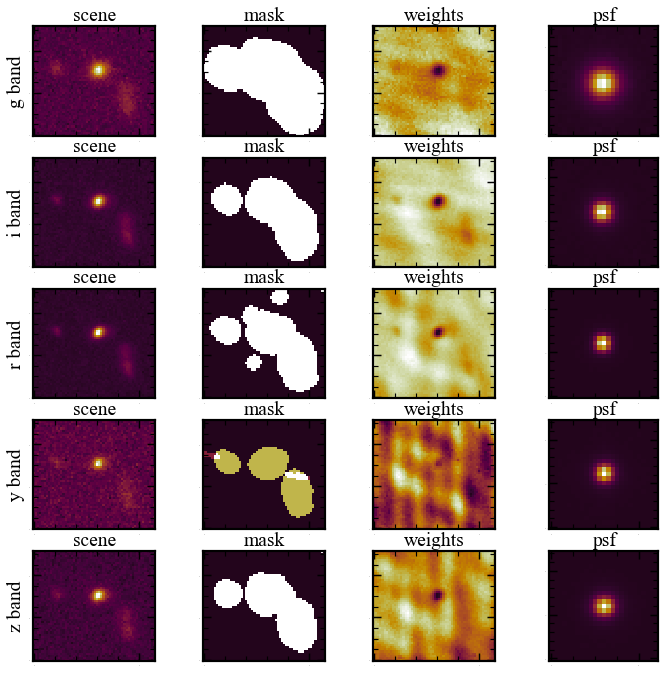

In [379]:
fig = plt.figure(figsize=(12, 12), dpi = 70)
num_bands = len(filters)
for i in range(num_bands):
    plt.subplot(num_bands,4,1+4*i)
    plt.title('scene', fontsize=20)
    plt.imshow( images[i] )
    name = filters[i] + ' band'
    plt.ylabel(name, fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.subplot(num_bands,4,2+4*i)
    plt.title('mask', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( masks[i] )
    plt.subplot(num_bands,4,3+4*i)
    plt.title('weights', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( weights[i] )
    plt.subplot(num_bands,4,4+4*i)
    plt.title('psf', fontsize=20)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    plt.imshow( multi_psf[i] )
plt.show()

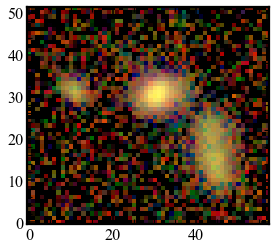

In [380]:
from scarlet.display import AsinhMapping
stretch = 0.2
Q = 7 # 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [381]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)

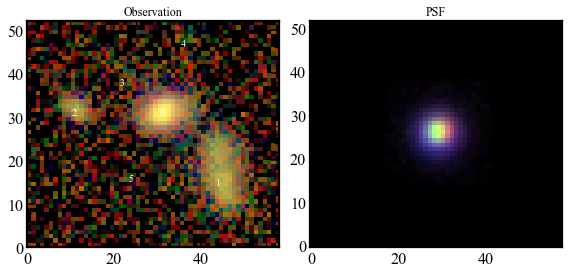

In [382]:
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True)
plt.show()

In [383]:
sources, skipped = scarlet.initialization.init_all_sources(model_frame,
                                                           centers,
                                                           observation,
                                                           max_components=2,
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=True
                                                          )

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

0: MultiExtendedSource
1: SingleExtendedSource
2: SingleExtendedSource
3: SingleExtendedSource
4: SingleExtendedSource
5: SingleExtendedSource


In [384]:
sources = []
for k,center in enumerate(centers):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, center, observation)
    elif k in [1, 2]:
        new_source = scarlet.ExtendedSource(model_frame, center, observation, K=2)
    elif k in [3, 5]:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, K=1)
    else:
         new_source = scarlet.ExtendedSource(model_frame, center, observation, compact=True)
    sources.append(new_source)

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

0: PointSource
1: MultiExtendedSource
2: MultiExtendedSource
3: SingleExtendedSource
4: CompactExtendedSource
5: SingleExtendedSource


CPU times: user 1.4 s, sys: 26.1 ms, total: 1.43 s
Wall time: 808 ms
scarlet ran for 100 iterations to logL = 11265.113653411241


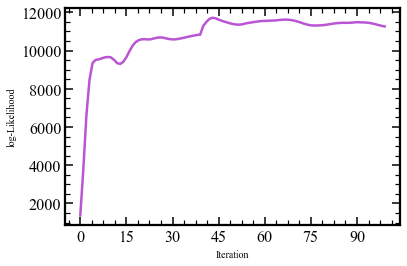

In [385]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

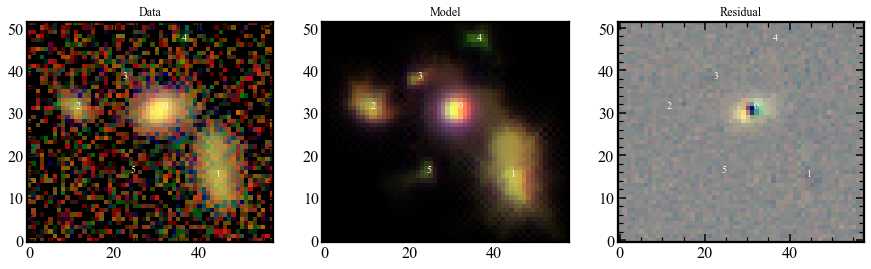

In [386]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

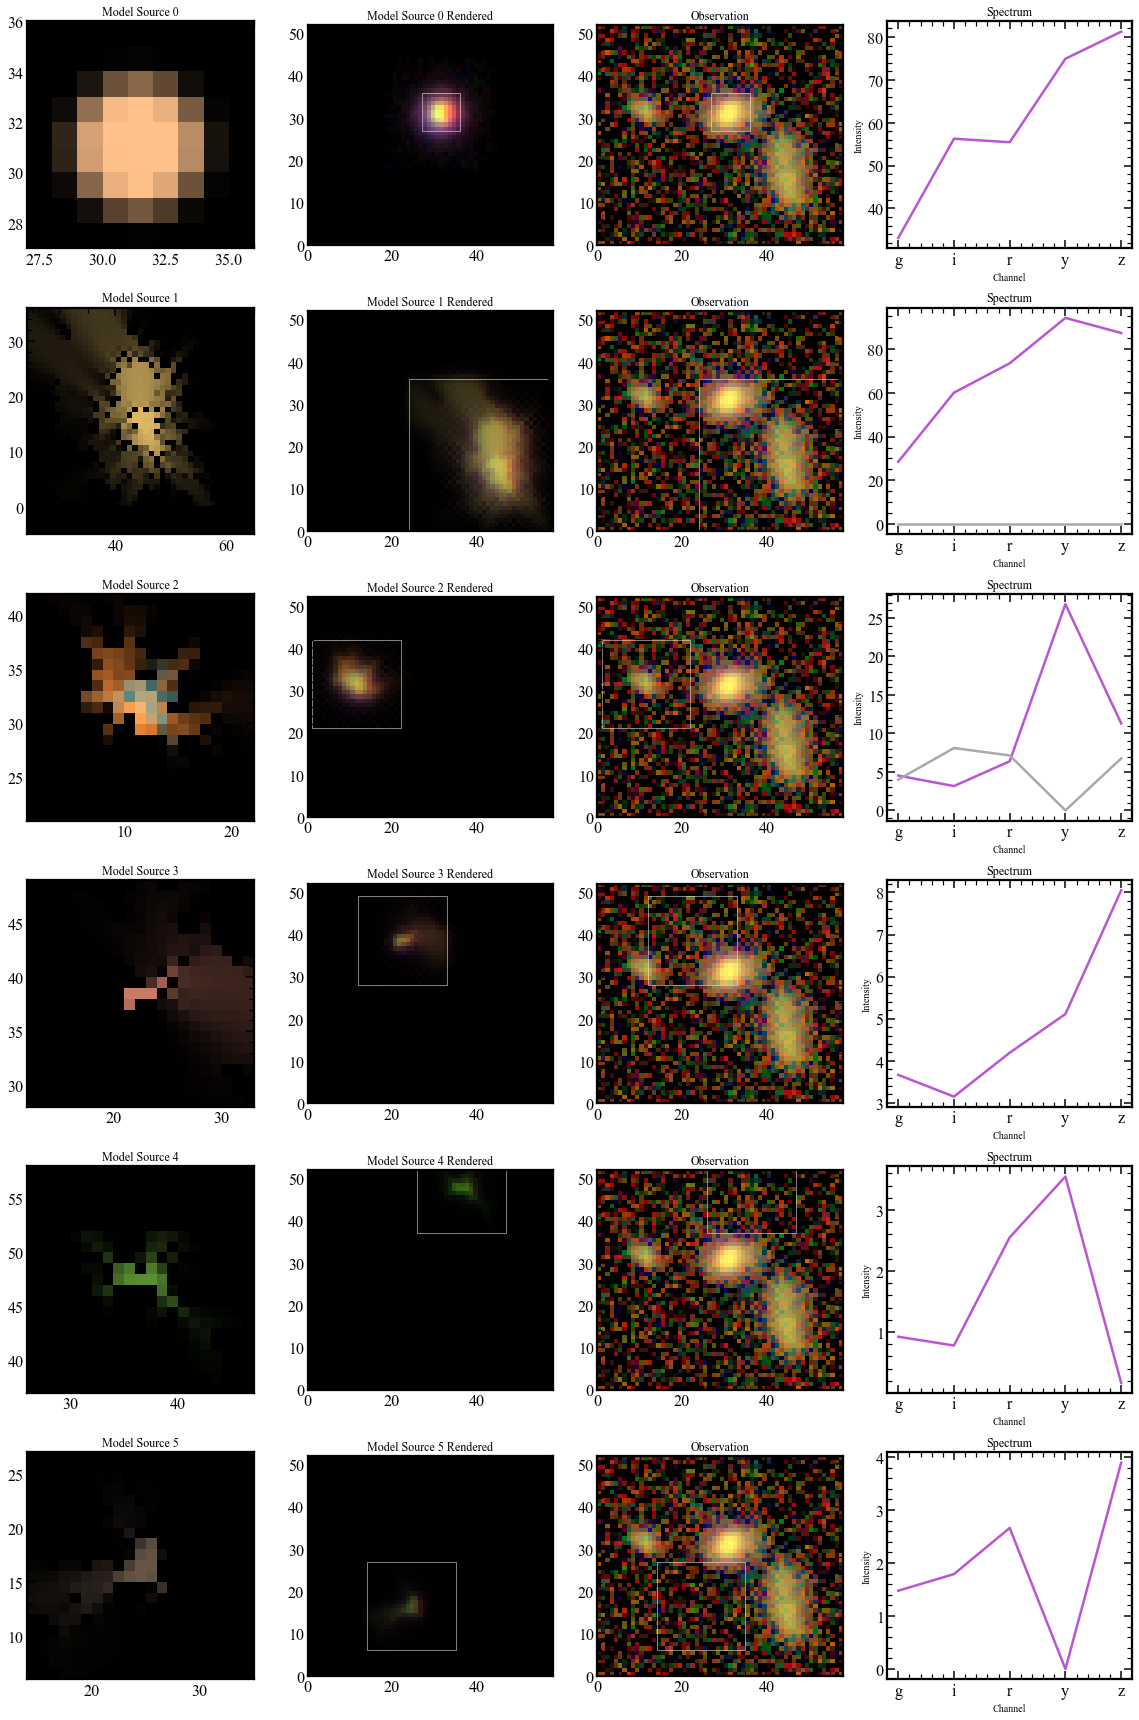

In [387]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation,
                             show_model=True,
                             show_rendered=True,
                             show_observed=True,
                             add_markers=False,
                             add_boxes=True
                            )
plt.show()

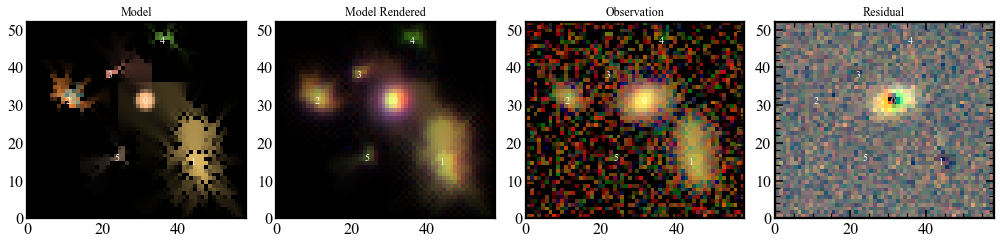

In [388]:

scarlet.display.show_scene(sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                           figsize=(14,3.5))
plt.savefig('scarlet1.pdf',facecolor='white',transparent=False ,dpi = 300)
plt.show()
